In [1]:
import os
import seaborn as sns
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from google.colab import drive


Mounted at /content/drive


In [2]:
drive.mount("/content/drive",force_remount=True)
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projects/2CarPrices/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projects/2CarPrices/test.csv')
pd.set_option('display.max_columns',len(train.columns))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
train=pd.read_csv(next(iter(files.upload().keys())))
test=pd.read_csv(next(iter(files.upload().keys())))

In [5]:
#assuming we dont need to normalize any data points
train.head(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


In [6]:
# @title info

def describe(df):
  desc=pd.DataFrame()
  desc['dtype']=df.dtypes
  desc['null']=df.isnull().sum()
  desc['%null'] = desc['null'] / len(df) * 100
  # desc['mean']=df.mean()
  # desc['median']=df.median()
  #desc['%unique'] = desc['nunique'] /len(df)*100
  desc = pd.concat([desc,df.describe(include = 'all').T],axis=1).sort_values(by='null',ascending=False)
  desc['count']=df.count()
  desc['unique']=df.nunique()
  pd.set_option('display.max_columns',len(desc.columns))
  # desc['freq/mean']=desc['freq'].fillna(desc['mean']).drop(['freq','mean'],axis=1)
  display(desc)
describe(train)


,dtype,null,%null,count,unique,top,freq,mean,std,min,25%,50%,75%,max
clean_title,object,21419,11.360876,167114,1,Yes,167114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel_type,object,5083,2.696080,183450,7,Gasoline,165940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident,object,2452,1.300568,186081,2,None reported,144514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,int64,0,0.000000,188533,188533,NaN,NaN,94266.0,54424.933488,0.0,47133.0,94266.0,141399.0,188532.0
brand,object,0,0.000000,188533,57,Ford,23088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,object,0,0.000000,188533,1897,F-150 XLT,2945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_year,int64,0,0.000000,188533,34,NaN,NaN,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,int64,0,0.000000,188533,6651,NaN,NaN,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
engine,object,0,0.000000,188533,1117,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,3462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,object,0,0.000000,188533,52,A/T,49904,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def cat_fea(train):


  unique_counts = train.nunique()
  #Threshold to distinguish continous and categorical
  threshold = 100

  continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
  categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()
  return continuous_vars,categorical_vars
cont,cat=cat_fea(train)

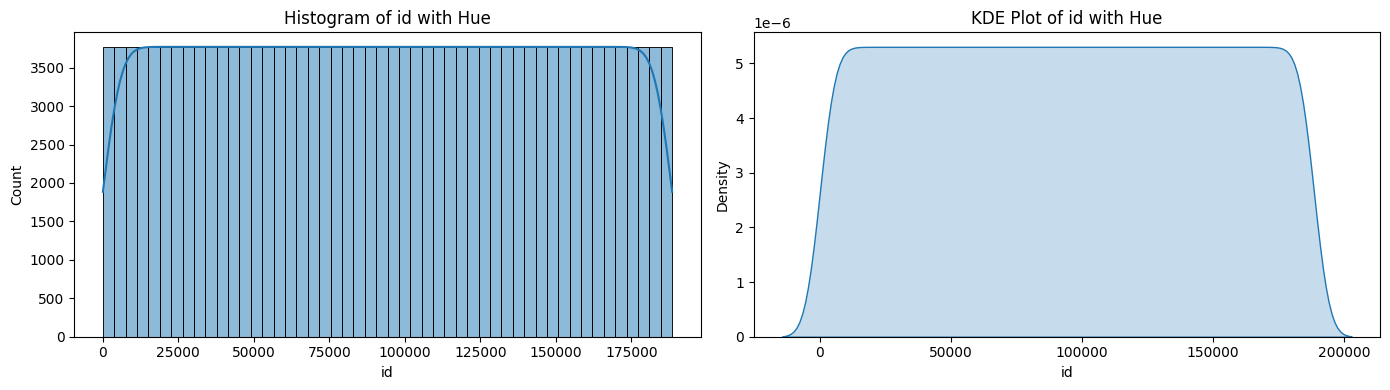

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

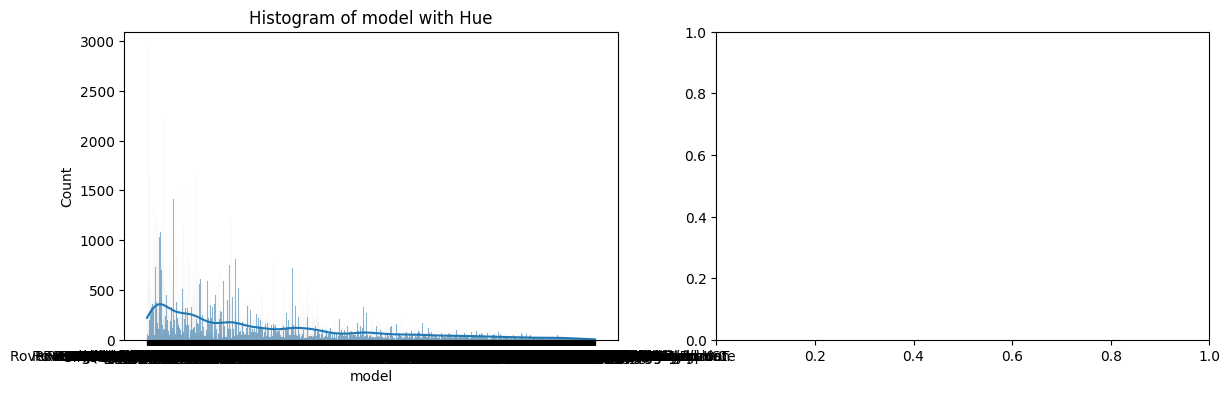

In [9]:
# @title continous feature disturbutions
def target3_plot(column,train):
      import warnings
      warnings.filterwarnings("ignore")
      hue_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
      fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # Create subplots with 1 row and 2 columns

      # Plot histogram with hue
      sns.histplot(data=train, x=column, hue_order=hue_columns, bins=50, kde=True, ax=axes[0])
      axes[0].set_title(f'Histogram of {column} with Hue')
      axes[0].set_xlabel(column)
      axes[0].set_ylabel('Count')
      # axes[0].legend(title='Fault Types', loc='upper right',fontsize="x-large")

      # Plot KDE plot with hue
      sns.kdeplot(data=train, x=column, shade=True,hue_order=hue_columns, ax=axes[1])
      axes[1].set_title(f'KDE Plot of {column} with Hue')
      axes[1].set_xlabel(column)
      axes[1].set_ylabel('Density')
      # axes[1].legend(title='Fault Types', loc='upper right',fontsize="x-large")

      plt.tight_layout()  # Adjust spacing between subplots
      plt.show()

for i in cont:
   target3_plot(i,train)


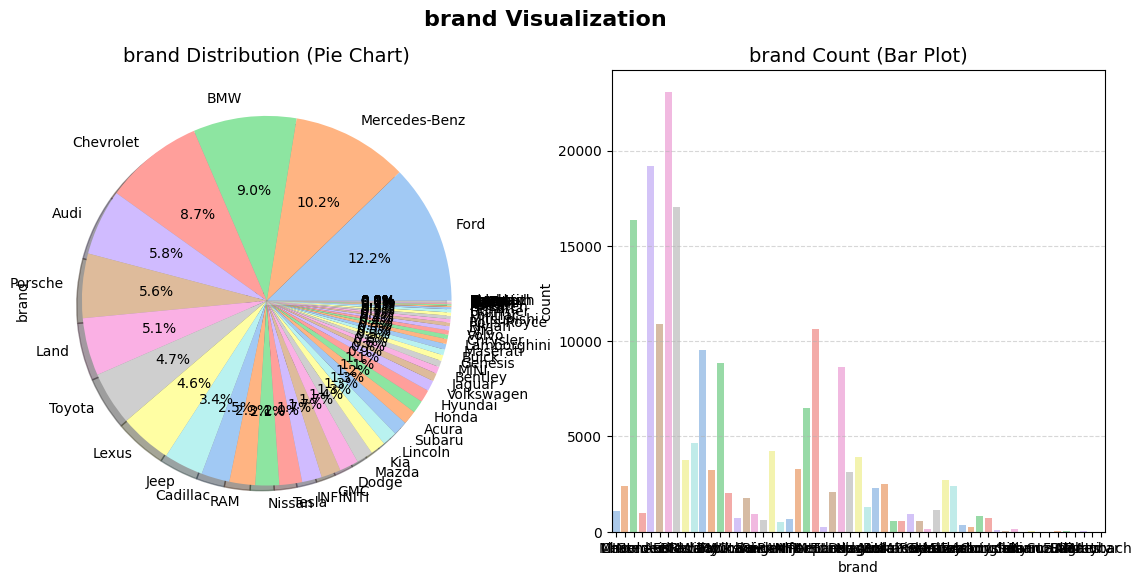

Columns in Target column are: brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            24

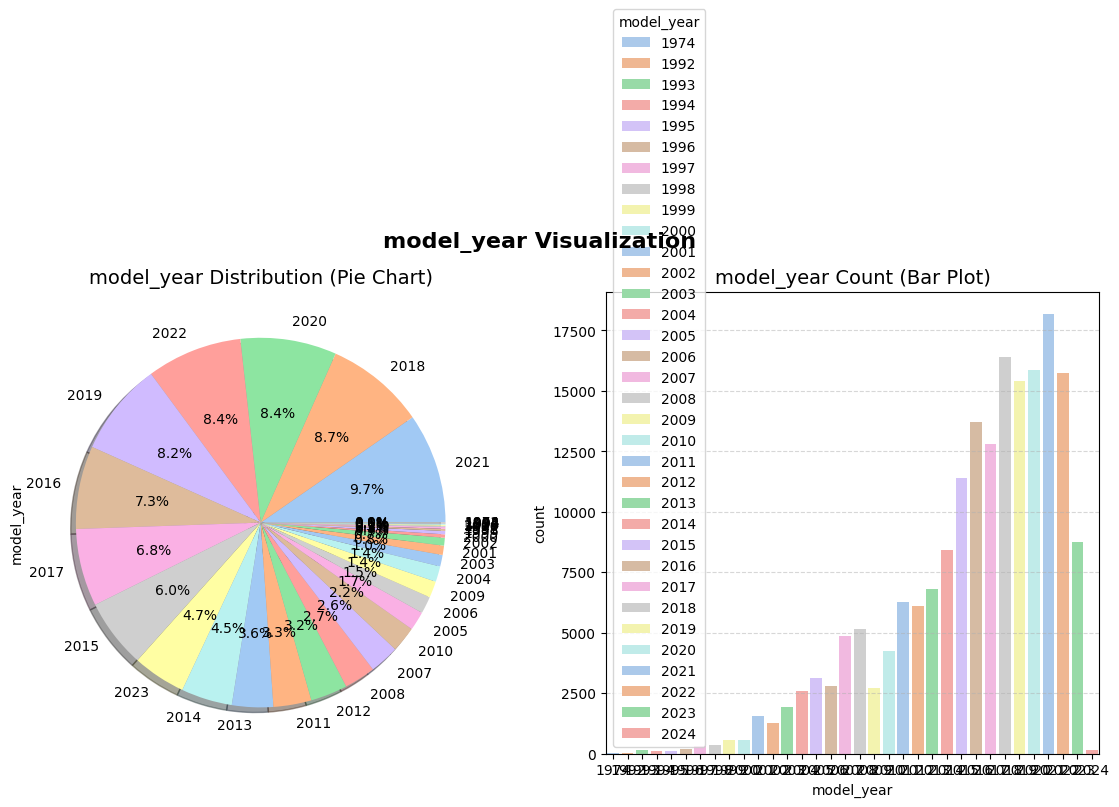

Columns in Target column are: model_year
2021    18198
2018    16414
2020    15848
2022    15749
2019    15409
2016    13696
2017    12794
2015    11389
2023     8769
2014     8415
2013     6796
2011     6265
2012     6095
2008     5156
2007     4876
2010     4235
2005     3129
2006     2814
2009     2716
2004     2570
2003     1906
2001     1534
2002     1282
2000      558
1999      554
1998      343
1997      312
1996      189
2024      162
1993      140
1995      102
1994       92
1992       14
1974       12
Name: count, dtype: int64


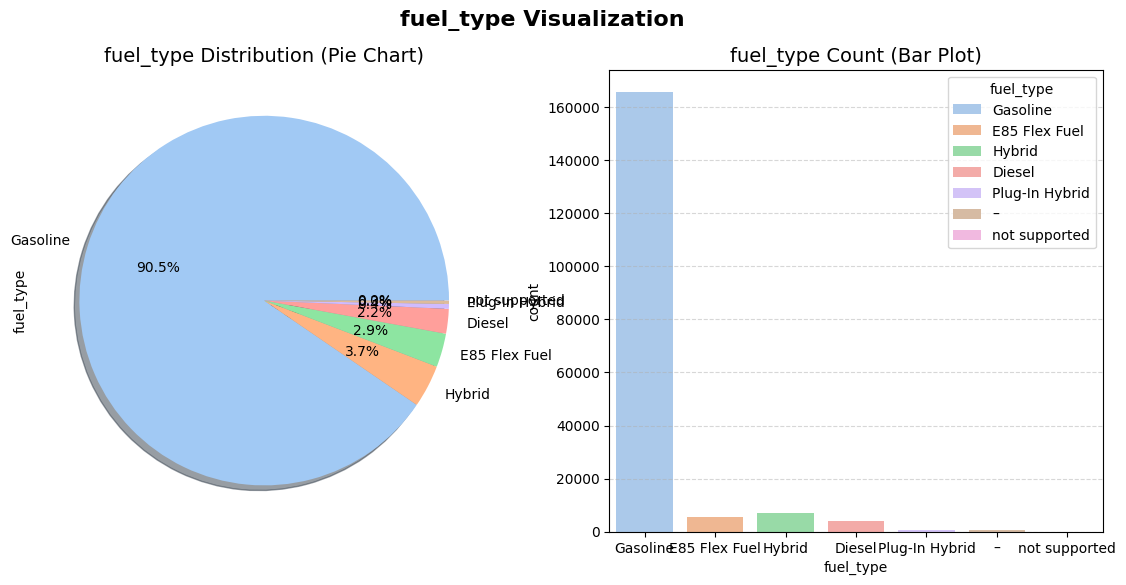

Columns in Target column are: fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


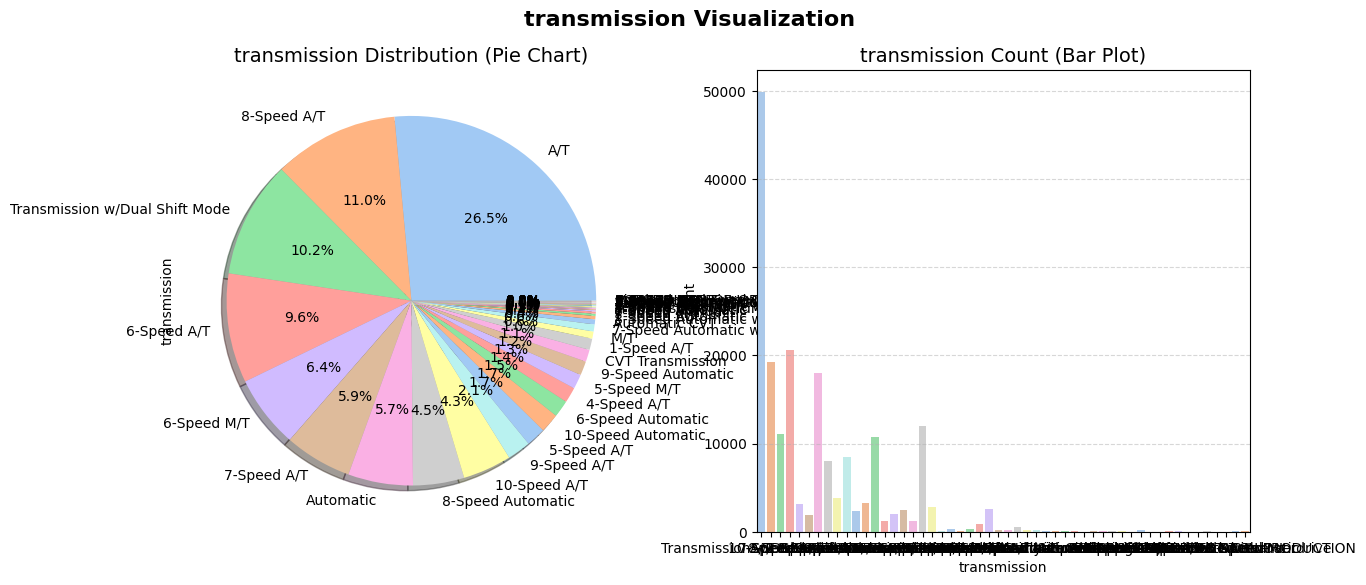

Columns in Target column are: transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      23

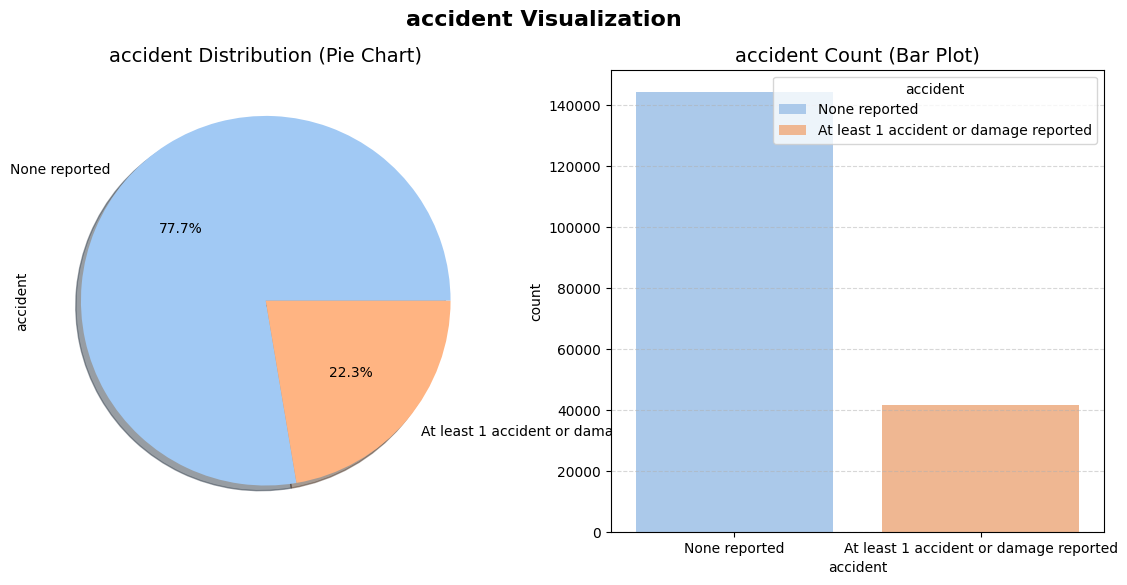

Columns in Target column are: accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64


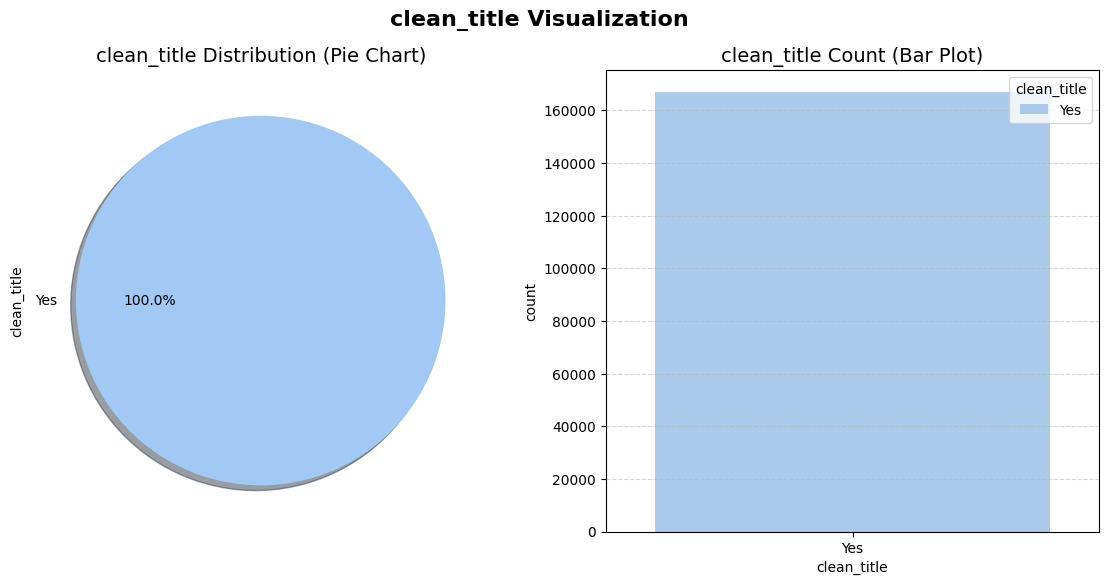

Columns in Target column are: clean_title
Yes    167114
Name: count, dtype: int64


In [8]:
# @title category feature disturbutions
import warnings
warnings.filterwarnings("ignore")
def target_plot(column,train):
    custom_palette = sns.color_palette("pastel")
    f, ax = plt.subplots(1, 2, figsize=(14,6))
    train[column].value_counts().plot.pie(autopct='%2.1f%%', ax=ax[0], shadow=True, colors=custom_palette)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column, data=train, ax=ax[1], palette=custom_palette,hue=column)
    ax[0].set_title(f'{column} Distribution (Pie Chart)', fontsize=14)
    ax[1].set_title(f'{column} Count (Bar Plot)', fontsize=14)
    plt.suptitle(f'{column} Visualization', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("Columns in Target column are:",train[column].value_counts())
for i in cat:
 target_plot(i,train)

In [12]:
# @title Spliting Train
train= train.drop_duplicates()

def split(Data,Target,id):
  y=Data[Target].copy()
  x=Data.drop([Target,id],axis=1).copy()
  return x,y
x,y=split(train,'price','id')

In [13]:
from sklearn import preprocessing

def encoder(data):
  for col in data.columns:
      if data.dtypes[col] == "object":
          le = preprocessing.LabelEncoder()
          le.fit(data[col])
          data[col] = le.transform(data[col])
  return data
x=encoder(x)


In [ ]:
#train test split
from sklearn.model_selection import train_test_split

xtr,xte,ytr,yte=train_test_split(x,y,test_size=0.2,shuffle=True,stratify=y )


In [16]:
# @title histgradient
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor()

model.fit(xtr,ytr)
model.score(xte,yte)

0.14953168050038312

In [ ]:
mo

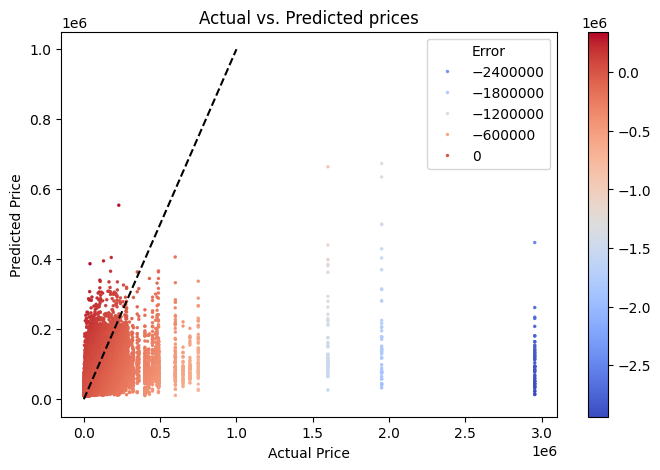

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Example data for Actual and Predicted prices
np.random.seed(42)
actual = y  # Random actual prices
predicted = model.predict(x) # Predicted prices with some noise

# Compute the difference (error) for color mapping
errors = predicted - actual

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted,
    'Error': errors
})

# Create the plot
plt.figure(figsize=(8, 5))

# Scatter plot with color based on the error
sns.scatterplot(x='Actual', y='Predicted', hue='Error', palette='coolwarm', data=df, edgecolor=None, s=5)

# Add a line for perfect predictions
plt.plot([0, 1e6], [0, 1e6], '--k', label='Perfect prediction')

# Add labels and title
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted prices')

# Add color bar for the error
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=min(errors), vmax=max(errors)))
sm.set_array([])
plt.colorbar(sm)

# Show the plot
plt.show()


In [19]:

l=model.predict(encoder(test.drop('id',axis=1)))
df=pd.DataFrame()
df['class']=l
df['id']=test['id']
df.to_csv("/content/drive/MyDrive/Colab Notebooks/projects/2CarPrices/sample_submission.csv", index=False)
